# <div style="font-family: Georgia, serif"><div style="text-align: center;color: #E67E02"><div><h1>Assignment 2</h1></div></div><div style="color: #0377DE; font-size: 20px"><span style="padding-right: 100px;">Name: Koushik Mahanta</span > <span>Roll No.: 002011001106</span></div></div>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [238]:
from sklearn.datasets import (load_iris, load_breast_cancer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def getModelScores(dataset, model_params, k_fold):
    """This function performs k_fold Grid search cross validation on 
    the dataset for all the models in `model_params` using all combinations 
    of configuraions mentioned for that model and returns a DataFrame 
    containing maximum test score configurations for each model"""
    scores = []
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], 
                            cv=5, 
                            return_train_score=False)
        
        clf.fit(dataset.data, dataset.target)
        
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        
    df = pd.DataFrame(scores,
                      columns=['model','best_score','best_params'])
    return df

In [248]:
def getTrainsizeAccuracies(dataset, 
                           classifier, 
                           random_state,
                           /, *, 
                           train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7],
                           **args
                          ):
    
    """
        This function takes a dataset, a classifier and an optional array containing 
        traing sizes. It computes model accuracy scores for each train-test split and
        displays a Model accuracy vs Training size plot
    """
    accuracies = []
    for train_size in train_sizes:
        X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
        if args:
            trained_model = classifier(**args).fit(X_train, y_train)
        else:
            trained_model = classifier().fit(X_train, y_train)
        y_prediction = trained_model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_prediction))
        
    # Plotting the Graph
    plt.plot(np.array(train_sizes)*100, np.array(accuracies)*100)
    plt.title("Model Accuracy vs Training Size")
    plt.xlabel("Training Size (%)")
    plt.ylabel("Model Accuracy (%)")
    plt.xticks(np.array(train_sizes)*100)
    plt.show()
        

In [231]:
iris_dataset = load_iris()

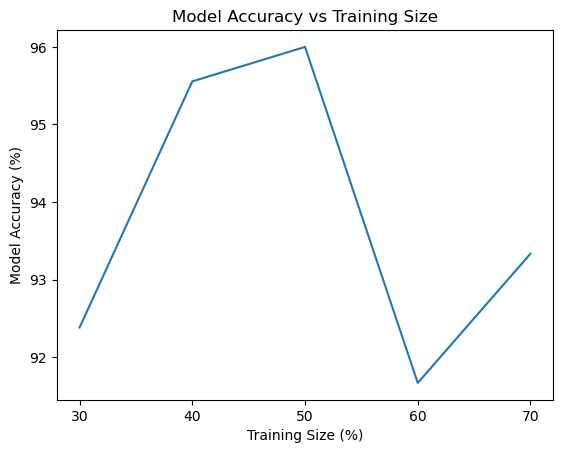

In [249]:
getTrainsizeAccuracies(iris_dataset,
                       SVC,
                       41)

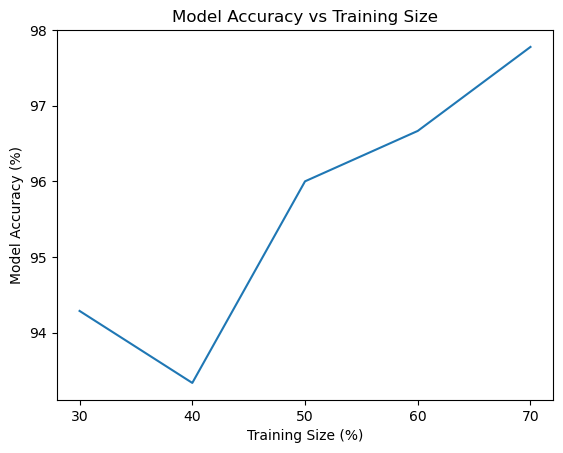

In [250]:
getTrainsizeAccuracies(iris_dataset,
                       RandomForestClassifier,
                       44)

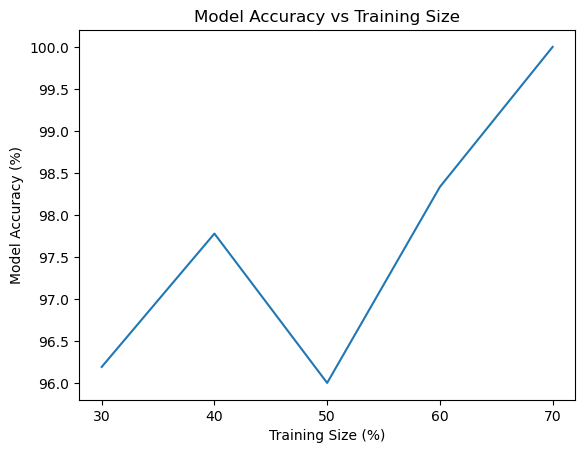

In [255]:
getTrainsizeAccuracies(iris_dataset,
                       MLPClassifier,
                       42,
                       max_iter=1000
                      )

In [345]:
def displaROCPlot(dataset, classifiers, train_size, random_state, /, **args):
    """"""
    X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
    r_probs = [0 for _ in range(len(y_test))]
    r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

    for classifier in classifiers:
        trained_model = classifier(**args[classifier.__name__]).fit(X_train, y_train)
        probabilities = trained_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probabilities)
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        plt.plot(fpr, tpr, marker='.', label='{0} (AUROC = {1:.3f})'.format(classifier.__name__, auc))
    
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

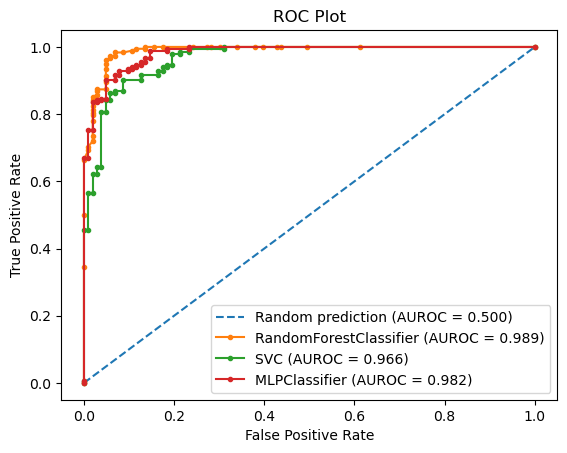

In [350]:
displaROCPlot(breast_cancer_dataset, [RandomForestClassifier, SVC, MLPClassifier], 0.5, 760, RandomForestClassifier={}, MLPClassifier={
    'max_iter':10000
}, SVC={
    'probability':True
})